In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import random
import math
from scipy.optimize import minimize as mini
from scipy.optimize import least_squares as ls
from scipy.optimize import leastsq
import pyOpt
from pyOpt import CONMIN
from pyOpt import Optimization

In [2]:
MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

MAG_VEGA_g = -0.08
MAG_VEGA_r = 0.16
MAG_VEGA_i = 0.37
MAG_VEGA_z = 0.54

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_LAMBDA_VEGA_g = 466.9*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_r = 278.0*10**(-11)
FLUX_LAMBDA_VEGA_i = 185.2*10**(-11)
FLUX_LAMBDA_VEGA_z = 131.5*10**(-11)

data = np.loadtxt('/home/lynge/MasterP/NOVEMBER/NOV-NGC3783-K')
error = np.loadtxt('/home/lynge/MasterP/NOVEMBER/NGC3783_NOISE_K.txt')

time1 = [1,2,3,4,5,6,7,8,9,10]
flux1 = [1,2,5,7,3,1,4,6,7,3]
sigma1 = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]


time1 = np.array(time1)
flux1 = np.array(flux1)
sigma1 = np.array(sigma1)

time = np.insert(time1,0,0)
sigma = np.insert(sigma1,0,np.mean(sigma1))
flux = np.insert(flux1,0,np.mean(flux1))

print time1
print sigma1
print flux1



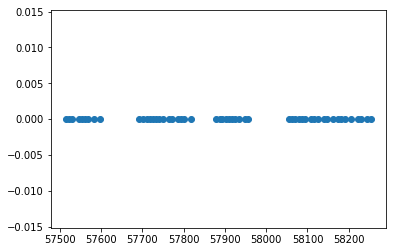

yes
yes
yes
yes
yes
yes 2
yes 2
yes
yes 2
yes
yes
yes 2
yes 2
yes 2
yes 2
[6.53692740e-15 6.68514248e-15 6.71358527e-15 6.60096834e-15
 6.37964425e-15 6.67127211e-15 6.56894523e-15 6.56946122e-15
 6.73956433e-15 6.98789842e-15 7.07148604e-15 7.16600928e-15
 7.44946060e-15 7.59712804e-15 7.59991812e-15 8.05729361e-15
 7.98165151e-15 8.24999301e-15 8.37994436e-15 9.20294591e-15
 9.21068297e-15 9.44032587e-15 9.50610473e-15 9.73302579e-15
 9.80485259e-15 9.78992681e-15 9.83974215e-15 9.76988550e-15
 9.45780882e-15 9.26152396e-15 9.16905037e-15 9.00022627e-15
 9.08750538e-15 8.92810696e-15 8.71962672e-15 8.86509304e-15
 8.82220032e-15 8.69549681e-15 8.84735230e-15 8.79111873e-15
 8.70469323e-15 8.69859061e-15 8.33132789e-15 8.29606268e-15
 8.38661892e-15 8.15085157e-15]
[    0. 57516. 57523. 57530. 57547. 57554. 57569. 57598. 57693. 57701.
 57711. 57719. 57726. 57733. 57741. 57749. 57764. 57772. 57801. 57817.
 57878. 57887. 57903. 57910. 57918. 57925. 57933. 57949. 57956. 58055.
 58062. 58

In [3]:
data = np.loadtxt('NOVEMBER/NOV-NGC3783-K')
error = np.loadtxt('NOVEMBER/NGC3783_NOISE_K.txt')

plt.figure()
plt.scatter(data[:,0],data[:,1])
plt.show()

#print data[:,0]
#print data[:,1]
#print error[:,0]
#print error[:,4]


time2 = data[:,0]
flux2 = data[:,1]
sigma2 = error[:,1]

time1 = []
flux1 = []
sigma1 = []
 

for i in range(len(time2)):
    if np.isnan(sigma2[i]):
        print 'yes'
    elif np.isnan(flux2[i]):
        print 'yes 2'
    else:
        time1.append(time2[i])
        flux1.append(flux2[i])
        sigma1.append(sigma2[i])

time1 = np.array(time1)
flux1 = np.array(flux1)
sigma1 = np.array(sigma1)

time = np.insert(time1,0,0)
sigma = np.insert(sigma1,0,np.mean(sigma1))
flux = np.insert(flux1,0,np.mean(flux1))

#sigma1 = -2.5*np.log10((flux1 + sigma1)/FLUX_LAMBDA_VEGA_K)
#sigma = -2.5*np.log10((flux + sigma)/FLUX_LAMBDA_VEGA_K)
#flux1 = -2.5*np.log10(flux1/FLUX_LAMBDA_VEGA_K)
#flux = -2.5*np.log10(flux/FLUX_LAMBDA_VEGA_K)

#sigma1 = abs(sigma1 - flux1)
#sigma = abs(sigma - flux)

print flux1

print time
print sigma
print flux

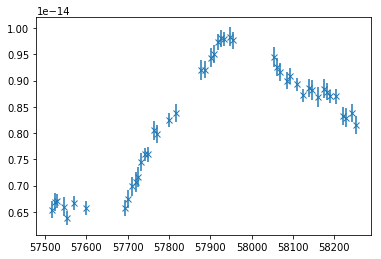

In [4]:
plt.figure()
plt.errorbar(time1,flux1,yerr=sigma1,fmt='x')
plt.show()

In [5]:
b = 8.*10**(-2)
tau = 500.
sigma_tot = 1*10**(-16)

param = [b,tau,sigma_tot]

In [6]:
'''x denotes the observed fluxes, and t the observation times, 
sigma is the error variances and p is the probability function'''

def a_i(t2,t1,tau):
    tau = float(tau)
    return np.exp(-(t2-t1)/tau)

def omega_0(tau,sigma_tot):
    return 0.5*tau*sigma_tot**2

def omega_i(omega_0,a_i,omega_before,sigma_before):
    return omega_0*(1-a_i**2) + a_i**2*omega_before*(1 - omega_before/(omega_before + sigma_before**2))

def x_hat_i(a_i,x_hat_before,omega_before,sigma_before,x_star_before):
    return a_i*x_hat_before + ((a_i*omega_before)/((omega_before + sigma_before**2)))*(x_star_before - x_hat_before)

def x_star_i(x_i,b,tau):
    return x_i - b*tau


In [7]:
def parameters(param):
    x_hat = [0]
    omega = [0.5*param[1]*param[2]**2]
    x_star = [-param[0]*param[1]]
    a = []
    for i in range(len(flux1)):
        a.append(a_i(time[i+1],time[i],param[1]))
        x_hat.append(x_hat_i(a[i],x_hat[i],omega[i],sigma[i],x_star[i]))
        omega.append(omega_i(omega_0(param[1],param[2]),a[i],omega[i],sigma[i]))
        x_star.append(x_star_i(flux[i+1],param[0],param[1]))
    x_hat[0] = np.mean(x_hat)
    x_hat[1] = np.mean(x_hat)
    return x_hat,omega,x_star,a


In [8]:
def prob(param):
    x_hat,omega,x_star,a = parameters(param)
    #print x_hat
    #print x_star
    #print omega
    
    probability = 1
    for i in range(len(a)):
        #print omega[i+1],sigma[i+1]**2 #,x_hat[i+1],x_star[i+1],a[i]
        #print (x_hat[i+1] - x_star[i+1])
        part = np.log(1/np.sqrt(2*np.pi*(omega[i+1] + sigma[i+1]**2)))\
        -(1/2.)*(((x_hat[i+1] - x_star[i+1])**2.)/(omega[i+1] + sigma[i+1]**2.))
        #print part,sigma1[i]
        #print ((x_hat[i+1] - x_star[i+1])**2.)/(omega[i+1] + sigma[i+1]**2.)
        #print 1/np.sqrt(2*np.pi*(omega[i+1] + sigma[i+1]**2))
        probability += part
        #print part, probability
    return -probability

In [9]:
def dX(tau,sigma,dt,b,epsilon,X):
    dt = dt
    sigma = sigma
    return (-(1/tau)*X*dt + sigma*np.sqrt(dt)*epsilon + b*dt)

def dX(tau,sigma,dt,b,epsilon,X):
    res = 0
    if X < b*tau:
        res = -(1/tau)*X*dt + sigma*np.sqrt(dt)*epsilon + b
    if X > b*tau:
        res = (1/tau)*X*dt + sigma*np.sqrt(dt)*epsilon - b
    return res

In [10]:
def flux_model(param):
    res = mini(prob,param,method='Nelder-Mead',tol=1e-18)
    tau = res.x[1] #1400. #res.x[1] #1400. #res.x[1]
    b = res.x[0] #9.2/tau #res.x[0] #7.5*10**(-15)/tau #res.x[0]
    sigma_tot = res.x[2] #0.01 #res.x[2] #1.3*10**(-16) #res.x[2] 
    model = np.zeros((2000,len(flux1)))
    flux_test = flux1[0]
    for j in range(len(model[:,0])):
        model[j,0] = flux1[0]
        #flux_model = [flux1[0]]
        #print j
        for i in range(len(flux1)-1):
            #print i, model[j,i]
            dt = (time1[i+1]-time1[i])
            epsilon = np.random.normal(0,1,1)
            dX1 = (flux1[i+1])#*(-1) + model[j,0]
            change = dX(tau,sigma_tot,dt,b,epsilon,dX1) #flux1[i+1] - flux1[i]
            #print change,flux1[i+1]
            model[j,i+1] = change + flux1[i] #model[j,i] # - flux_test)
    model2 = []
    time_model = []
    std = []
    for i in range(len(model[0,:])):
        model2.append(np.mean(model[:,i]))
        std.append(np.std(model[:,i]))
        time_model.append(time1[i])
    flux_model = np.array((time_model,model2,std,res.x))
    return flux_model,time_model, model2

#model, time_model, model2 = flux_model(param)

def flux_model1(param):
    res = mini(prob,param,method='Nelder-Mead',tol=1e-18)
    tau = res.x[1] #1400. #res.x[1] #1400. #res.x[1]
    b = res.x[0] #9.2/tau #res.x[0] #7.5*10**(-15)/tau #res.x[0]
    sigma_tot = res.x[2] #0.01 #res.x[2] #1.3*10**(-16) #res.x[2] 
    model = np.zeros((2000,len(flux1)))
    flux_test = flux1[0]
    dx_day = np.zeros((2000,len(flux1)))
    timef = time1[::-1]
    fluxf = flux1[::-1]
    #print timef, time1
    for j in range(len(model[:,0])):
        model[j,0] = fluxf[0]
        for i in range(len(fluxf)-1):
            dt = abs(timef[i+1]-timef[i])
            epsilon = np.random.normal(0,1,1)
            dX1 = (fluxf[i+1])#*(-1) + model[j,0]
            change = dX(tau,sigma_tot,dt,b,epsilon,dX1) #flux1[i+1] - flux1[i]
            model[j,i+1] = change + fluxf[i] #model[j,i] # - flux_test)
            dx_day[j,i+1] = change/dt
            #print 2
    model2 = []
    time_model = []
    std = []
    dx_days = []
    for i in range(len(model[0,:])):
        model2.append(np.mean(model[:,i]))
        std.append(np.std(model[:,i]))
        time_model.append(timef[i])
        dx_days.append(np.mean(dx_day[:,i]))
        #print 2
    flux_model = np.array((time_model,model2,std,res.x))
    return flux_model,time_model[::-1], model2[::-1], dx_days[::-1]

In [11]:
model, time_model, model2 = flux_model(param) #p1.join()
model1, time_model1, model12, dx_days1 = flux_model1(param) #p2.join()
#model = np.add(model,model1)/2.
time_model = np.add(time_model,time_model1)/2.
model2 = np.add(model2,model12)/2.

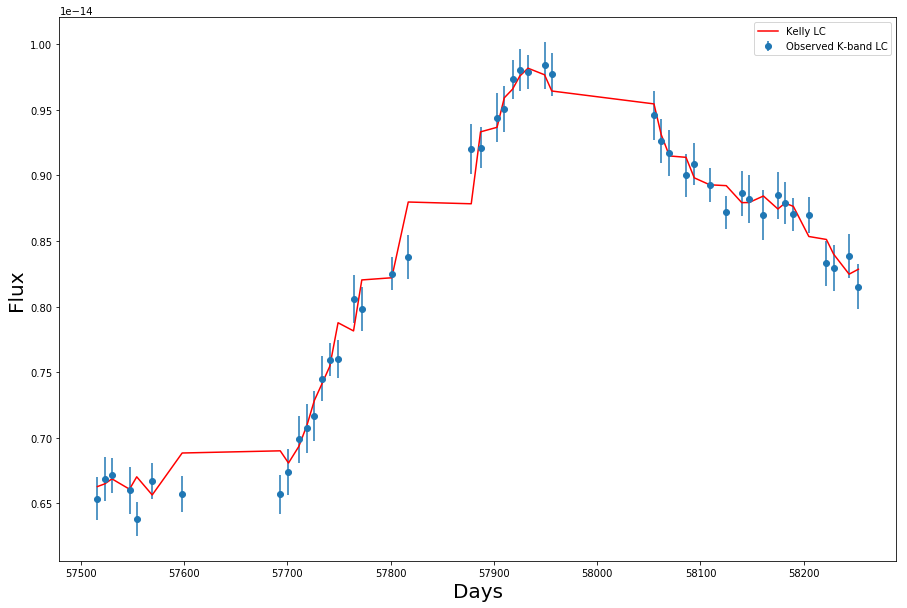

"\nplt.figure(figsize=(15,10))\nplt.errorbar(time1,flux1,yerr=sigma1,fmt='x')\nfor i in range(len(model[:,0])):\n    plt.plot(time1,model[i,:],linestyle='-')\n#plt.ylim([4e-15,1.2e-14])\nplt.show()\n\nplt.figure(figsize=(15,10))\nplt.errorbar(time1,flux1,yerr=sigma1,fmt='x')\n#plt.ylim([4e-15,1.2e-14])\nplt.show()\n"

In [12]:
plt.figure(figsize=(15,10))
plt.errorbar(time1,flux1,yerr=sigma1,fmt='o',label='Observed K-band LC')
plt.plot(time_model,model2,linestyle='-',color='r',label='Kelly LC')
plt.xlabel('Days',fontsize=20)
plt.ylabel('Flux',fontsize=20)
plt.legend()
#plt.errorbar(time_model,model2,yerr=std,fmt='.',color='r')
#plt.ylim([4e-15,1.2e-14])
plt.show()
'''
plt.figure(figsize=(15,10))
plt.errorbar(time1,flux1,yerr=sigma1,fmt='x')
for i in range(len(model[:,0])):
    plt.plot(time1,model[i,:],linestyle='-')
#plt.ylim([4e-15,1.2e-14])
plt.show()

plt.figure(figsize=(15,10))
plt.errorbar(time1,flux1,yerr=sigma1,fmt='x')
#plt.ylim([4e-15,1.2e-14])
plt.show()
'''

In [41]:
print np.random.normal(0,1,1)

[-1.10424083]
